# New York High School SAT Scores (2010 - 2011)
The Scholastic Aptitude Test (SAT), is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests, and whether they're unfair to certain groups. Given our prior knowledge of this topic, investigating the correlations between SAT scores and demographics might be an interesting angle to take. We could correlate SAT scores with factors like race, gender, income, and more.

Here are the links to all of the data sets we'll be using:

 - [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
 - [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
 - [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
 - [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
 - [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
 - [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

# Part 1: Data Cleaning

We'd want to merge our various data sets into one combined set. To do that, we need to find or create a column that is consistent across all sets to allow for a merge. We also need to clean up null values within our data sets.

In [8]:
import pandas as pd

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for d in data_files:
    name = d.replace(".csv","")
    data[name] = pd.read_csv("/Users/chesterjohn/Desktop/dataquest/data/high-school-sat/" + d)
    
all_survey = pd.read_csv("/Users/chesterjohn/Desktop/dataquest/data/high-school-sat/survey_all.txt",delimiter="\t",encoding="windows-1252")

d75_survey = pd.read_csv("/Users/chesterjohn/Desktop/dataquest/data/high-school-sat/survey_d75.txt",delimiter="\t",encoding="windows-1252")

survey = pd.concat([all_survey,d75_survey],axis=0)

for k,v in data.items():
    print(data[k].head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

From the previous of our data set, it appears that each set either have a DBN (District Borough Number) column, or the information we need to create one. That means we can use a DBN column to combine the data sets. First we'll pinpoint matching rows from different data sets by looking for identical DBNs, then group all of their columns together in a single data set. To do this we should start cleaning our data.

In [9]:
survey["DBN"] = survey["dbn"]

survey = survey[["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]]

data["survey"] = survey

Above, I've started with cleaning up the concatenated survey data set. I standardised "dbn" to "DBN", and kept only columns that matter for our analysis by looking at the data dictionary.

In [10]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(row):
    if row <= 9:
        padded = str(row).zfill(2)
        return str(padded)
    else:
        return str(row)
      
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

Above, the "class_size" data set doesn't have a DBN column. However, the DBN is just the CSD and School Code appended to each other which this data set contains. We have combined them and created a new column for DBN.

In [11]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data["sat_results"]["sat_score"] = data["sat_results"]["SAT Math Avg. Score"] + data["sat_results"]["SAT Critical Reading Avg. Score"] + data["sat_results"]["SAT Writing Avg. Score"]

print(data["sat_results"]["sat_score"].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


Above, we have made a new column that totals up the SAT scores for the different sections of the exam. This will make it much easier to correlate scores with demographic factors because we'll be working with a single number, rather than three different ones.

In [16]:
import re

def extract_lat(location):
    coordinates = re.findall("\(.+\)",location)
    latitude = coordinates[0].split(",")[0].replace("(","")
    return latitude
    
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(extract_lat)

def extract_lon(location):
    coordinates = re.findall("\(.+\)",location)
    longitude = coordinates[0].split(",")[1].replace(")","")
    return longitude
    
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(extract_lon)

cols = ["lat","lon"]

for c in cols:
    data["hs_directory"][c] = pd.to_numeric(data["hs_directory"][c], errors="coerce")
    
print(data["hs_directory"].head(3))

      dbn                                  school_name      boro  \
0  17K548          Brooklyn School for Music & Theatre  Brooklyn   
1  09X543             High School for Violin and Dance     Bronx   
2  09X327  Comprehensive Model School Project M.S. 327     Bronx   

  building_code  phone_number    fax_number grade_span_min  grade_span_max  \
0          K440  718-230-6250  718-230-6262              9              12   
1          X400  718-842-0687  718-589-9849              9              12   
2          X240  718-294-8111  718-294-8109              6              12   

  expgrade_span_min  expgrade_span_max    ...      \
0               NaN                NaN    ...       
1               NaN                NaN    ...       
2               NaN                NaN    ...       

                        priority05 priority06 priority07 priority08  \
0                              NaN        NaN        NaN        NaN   
1                              NaN        NaN        NaN   

Above, we have captured the latitude and longitude coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field Location 1 in the hs_directory data set.

Some data sets e.g. class_size have multiple DBN values (because of multiple Grades, Program Types, and Core Course/Subject associated with a certain DBN). To merged our data sets into a combined data set, we first need to condense some of our data sets to produce a unique DBN value.

In [19]:
import numpy as np

class_size = data["class_size"]

class_size = class_size[(class_size["GRADE "] == "09-12") & (class_size["PROGRAM TYPE"] == "GEN ED")]

class_size = class_size.groupby("DBN")
class_size = class_size.agg(np.mean)
class_size.reset_index(inplace=True)

data["class_size"] = class_size

print(data["class_size"].head(1))

      DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292    1                               88.0                 4.0   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                    18.5              26.571429   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  


Above, we filtered class_size, then grouped them by dbn then got the average class_size for each DBN (as there were multiple class sizes for different subjects).

In [20]:
demographics = data["demographics"]

demographics = demographics[demographics["schoolyear"] == 20112012]

data["demographics"] = demographics

print(data["demographics"].head(1))

      DBN                                              Name  schoolyear  \
6  01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   

  fl_percent  frl_percent  total_enrollment prek   k grade1 grade2    ...      \
6        NaN         89.4               189   13  31     35     28    ...       

  black_num black_per hispanic_num hispanic_per white_num white_per male_num  \
6        63      33.3          109         57.7         4       2.1     97.0   

  male_per female_num female_per  
6     51.3       92.0       48.7  

[1 rows x 38 columns]


Above we condensed demographics, which is relatively easier.

In [21]:
grad = data["graduation"]

data["graduation"] = grad[(grad["Cohort"] == "2006") & (grad["Demographic"] == "Total Cohort")]

print(data["graduation"].head(1))

    Demographic     DBN                            School Name Cohort  \
3  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2006   

   Total Cohort Total Grads - n Total Grads - % of cohort Total Regents - n  \
3            78              43                     55.1%                36   

  Total Regents - % of cohort Total Regents - % of grads  \
3                       46.2%                      83.7%   

             ...            Regents w/o Advanced - n  \
3            ...                                  36   

  Regents w/o Advanced - % of cohort Regents w/o Advanced - % of grads  \
3                              46.2%                             83.7%   

  Local - n Local - % of cohort Local - % of grads Still Enrolled - n  \
3         7                  9%              16.3%                 16   

  Still Enrolled - % of cohort Dropped Out - n Dropped Out - % of cohort  
3                        20.5%              11                     14.1%  

[1 rows x 23 

The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [22]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")
    
print(data["ap_2010"].head())

      DBN                             SchoolName  AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.             39.0   
1  01M450                 EAST SIDE COMMUNITY HS             19.0   
2  01M515                    LOWER EASTSIDE PREP             24.0   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH            255.0   
4  02M296  High School of Hospitality Management              NaN   

   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               49.0                                  10.0  
1               21.0                                   NaN  
2               26.0                                  24.0  
3              377.0                                 191.0  
4                NaN                                   NaN  


We're almost ready to combine all of the data sets. The only remaining thing to do is convert the Advanced Placement (AP) test scores from strings to numeric values. We can now finally merge!!!

# Part 2: Merging our Data

We will start merging our data two sets at a time. Because our focus is on analysing factors effecting SAT scores (our dependent variable), we will left-join "sat_results" with "ap_2010" and "graduation" which als have quite many missing DBN values.

In [24]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

print(combined.head(1))
print(combined.shape)

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score SchoolName  \
0                404.0                   363.0     1122.0        NaN   

   AP Test Takers   Total Exams Taken            ...             \
0              NaN                NaN            ...              

   Regents w/o Advanced - n Regents w/o Advanced - % of cohort  \
0                        36                              46.2%   

  Regents w/o Advanced - % of grads Local - n  Local - % of cohort  \
0                             83.7%         7                   9%   

  Local - % of grads Still Enrolled - n Still Enrolled - % of cohort  \
0              16.3%                 16                        20.5%   

  Dropped Out - n Dropped Out - % of cohort  
0          

From the above, we end up with new columns from the merged sets, but retain the number of rows from "sat_results" as the additional rows from the other sets with missing DBN values are not included.

In [25]:
combined = combined.merge(data["class_size"], on="DBN", how="inner")
combined = combined.merge(data["demographics"], on="DBN", how="inner")
combined = combined.merge(data["survey"], on="DBN", how="inner")
combined = combined.merge(data["hs_directory"], on="DBN", how="inner")

print(combined.head(1))
print(combined.shape)

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score SchoolName  \
0                404.0                   363.0     1122.0        NaN   

   AP Test Takers   Total Exams Taken    ...     \
0              NaN                NaN    ...      

                                priority04                       priority05  \
0  Then to Manhattan students or residents  Then to New York City residents   

  priority06 priority07  priority08 priority09 priority10  \
0        NaN        NaN         NaN        NaN        NaN   

                                          Location 1        lat       lon  
0  220 Henry Street\nNew York, NY 10002\n(40.7137...  40.713764 -73.98526  

[1 rows x 159 columns]
(363, 159)


Above, because these sets contain information that's more valuable to our analysis and also have fewer missing DBN values, I have used the inner join type.

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

print(combined.head(5))

To avoid errors from running analyses on null values, we have filled null values with either the mean of the column, or if the whole row is made up of null values we will fill them up with 0.

In [28]:
def get_district(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_district)
print(combined["school_dist"].head())

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


Above, mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

# Part 3: Data Analysis
Now the fun part starts! First let's take a look at our correlation coefficient for all column values with "sat_score".

In [31]:
import matplotlib as plt
from mpl_toolkits.basemap import Basemap

correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

A general rule of thumb states that having an r => 0.25 or -0.25 is enough for it to be considered interesting and is the benchmark we will use for this analysis.

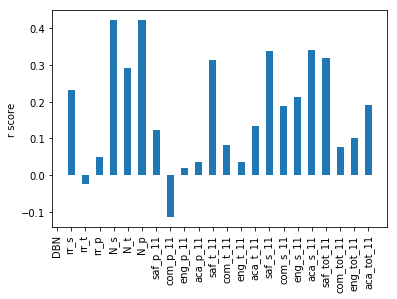

In [112]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
survey_fields = data["survey"].columns
survey_len = len(survey_fields)

bar_heights = correlations[survey_fields].values
bar_positions = np.arange(survey_len)

fig, ax = plt.subplots()
ax.bar(bar_positions,bar_heights, 0.5)
ax.set_xticklabels(survey_fields, rotation=90)
ax.set_ylabel("r score")
ax.set_xticks(range(0,survey_len))
plt.show()

The strongest positive correlation is seen by Number of Student Respondents "N_s" and Number of Parent Respondents "N_p" with both above r = 0.4, while Number of Teacher Respondents is less but still noteworthy at 0.3. This could mean a few things: i) we can infer that if respondents are willing/motivated to fill in the survey, means they would also be motivated to do well in exams; ii) higher response rates are due to higher total enrollment rates,"total_enrollment", in the school with r =  0.37.


Other notable results are Safety and Respect Scores by all parents "saf_p_11", students "saf_s_11",  and teachers "saf_t_11". This would make sense as it is only resonable that an enviroment that is safe and promotes respect for teachers can only do good for the students' academic results. This we can take a look into further.

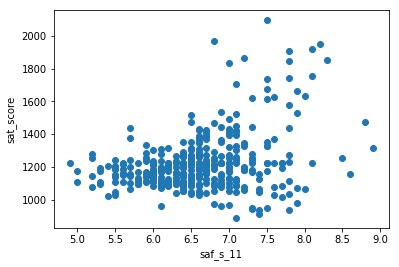

In [93]:
fig, ax = plt.subplots()

x_axis = combined["saf_s_11"]
y_axis = combined["sat_score"]
ax.scatter(x_axis,y_axis)
ax.set_xlabel("saf_s_11")
ax.set_ylabel("sat_score")
plt.show()

There seem to be a positive correlation between "saf_s_11" and "sat_score". However, many of our observations are cluttered between the 1100 - 1300 SAT score range, especially below the 7.0 mark for Safety score. There are quite a few schools with very high SAT scores beyond the 7.0 mark, while those before do not have marks above 1500. Now, it'd be interesting to see in which districts these schools belong to.

/Users/chesterjohn/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/chesterjohn/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/chesterjohn/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


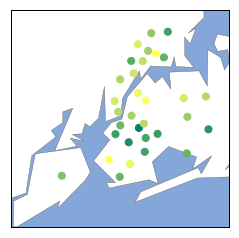

In [105]:
districts = combined.groupby("school_dist").agg(np.mean)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

It seems that schools in and close to The Bronx have, (unsurprisingly) low Safety scores, especially compared to those within Brooklyn. Next, because we have racial data in our combined data set, let's see if, Asians really do excel at school better than other races (i know, it's such a stereotype, but that's what why data is useful to dispel any misconcieved ideas!)

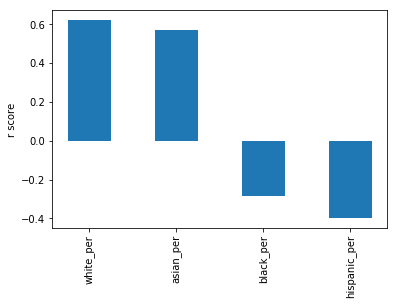

In [140]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]

race_len = len(races)

bar_heights = correlations[races].values
bar_positions = np.arange(race_len)

fig, ax = plt.subplots()
ax.bar(bar_positions,bar_heights, 0.5)
ax.set_xticklabels(races, rotation=90)
ax.set_ylabel("r score")
ax.set_xticks(range(0,race_len))
plt.show()

The above shows that a higher percentage of whites and/or asians in a school correlates to higher SAT scores, while the opposite is observed for the percentage of black and hispanic students. It could be that whites and asians student are often found in schools in a more affluent area, and have access to more resources.

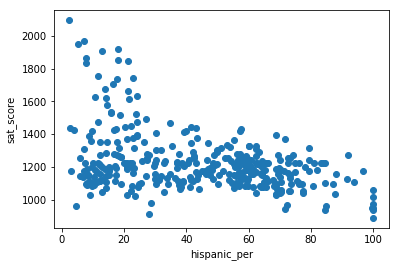

In [113]:
fig, ax = plt.subplots()

x_axis = combined["hispanic_per"]
y_axis = combined["sat_score"]
ax.scatter(x_axis,y_axis)
ax.set_xlabel("hispanic_per")
ax.set_ylabel("sat_score")
plt.show()

It seems that most observations are within the 1000 - 1300 SAT score range, with purely hispanic schools showing the lowest scores while on the opposite end, schools with little or virtually zero hispanic population have higher scores. It could mean that these students are in International schools focusing on teaching and learning English which have historically have lower SAT stores. Let's research the names of schools with 95% of greater hispanic representation and those with 5% or less.

In [132]:
hispanic_95 = combined[combined["hispanic_per"] >= 95]
print(hispanic_95["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools above seem to focus on new immigrant children focusing on learning english.

In [138]:
hispanic_5 = combined[(combined["hispanic_per"] <= 10) & (combined["sat_score"] >= 1800)]
print(hispanic_5["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools above focus more on STEM (e.g. Science, IT, Chemistry etc) subjects, with alot of resources, and with strict admission processes - from this we can infer that students in these schools already excel academically and are more likely to have higher SAT scores.

Next, we'll shift focus to again a contentious issue - gender. We have columns 'male_per' and 'female_per' for this analysis.

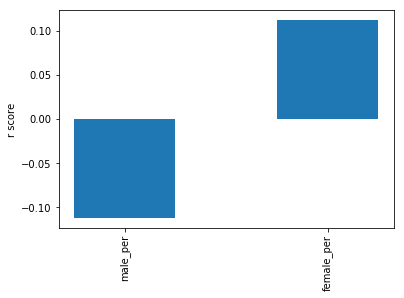

In [142]:
gender = ["male_per", "female_per"]

gender_len = len(gender)

bar_heights = correlations[gender].values
bar_positions = np.arange(gender_len)

fig, ax = plt.subplots()
ax.bar(bar_positions,bar_heights, 0.5)
ax.set_xticklabels(gender, rotation=90)
ax.set_ylabel("r score")
ax.set_xticks(range(0,gender_len))
plt.show()

Both male and female correlations with SAT scores have low r scores (roughly r = 0.1). This means that SAT scores is unlikely to be correlated with the percentage of male/female within the school.

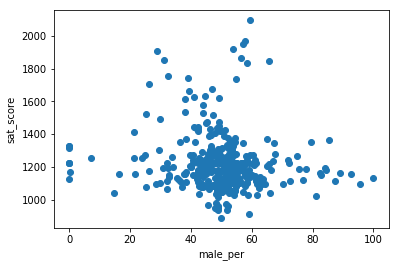

In [144]:
fig, ax = plt.subplots()

x_axis = combined["male_per"]
y_axis = combined["sat_score"]
ax.scatter(x_axis,y_axis)
ax.set_xlabel("male_per")
ax.set_ylabel("sat_score")
plt.show()

From the scatter plot we can see visually that there seem to be no sort of correlation between "male_per" and "sat_score". However, we an see that most observersations are within the 40 to 60 range, showing a healthy mix of male and female in schools.

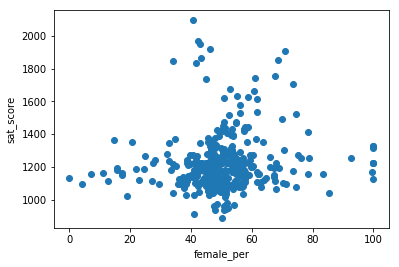

In [146]:
fig, ax = plt.subplots()

x_axis = combined["female_per"]
y_axis = combined["sat_score"]
ax.scatter(x_axis,y_axis)
ax.set_xlabel("female_per")
ax.set_ylabel("sat_score")
plt.show()

Again, very similar to the scatter plot on males. However, there are a good number of schools with high female representation (60 to 80%) with scores from 1600 and above. Let's investigate these schools.

In [149]:
female_majority = combined[(combined["female_per"] >= 60) & (combined["sat_score"] >= 1700)]
print(female_majority["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Again, these schools are known to have high academic excellence. There is a good mix of STEM and Arts focused schools.

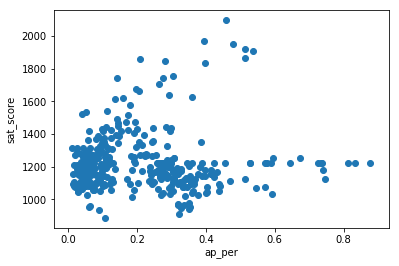

In [153]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

fig, ax = plt.subplots()

x_axis = combined["ap_per"]
y_axis = combined["sat_score"]
ax.scatter(x_axis,y_axis)
ax.set_xlabel("ap_per")
ax.set_ylabel("sat_score")
plt.show()

There seem to be a positive correlation, but it doesn't seem to be very strong. We can see for schools with higher than 40% of students who've sat for the AP exam exhibiting SAT stores barely greater than 1200.